In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [21]:
# Hisse senedi verisi indirme
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2023-01-01")

# Hareketli ortalamalar ve hedef sütun oluşturma
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
data['Target'] = data['Close'].shift(-1)

# Eksik verileri temizleme
data = data.dropna()

# Veri çerçevesini kontrol etme
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2020-10-15  117.833580  120.709999  121.199997  118.150002  118.720001   
2020-10-16  116.183853  119.019997  121.550003  118.809998  121.279999   
2020-10-19  113.216301  115.980003  120.419998  115.660004  119.959999   
2020-10-20  114.709839  117.510002  118.980003  115.629997  116.199997   
2020-10-21  114.085083  116.870003  118.709999  116.449997  116.669998   

Price          Volume        MA50      MA200      Target  
Ticker           AAPL                                     
Date                                                      
2020-10-15  112559200  116.922999  88.593500  119.019997  
2020-10-16  115393800  117.025349  88.813162  115.980003  
2020-10-19  120639300  117.122699  89.021275  117.510002  
2020-10-20  124423700  117.218349  89.234075  116.870

In [22]:
# Özellik ve hedef değişkenleri tanımlama
features = data[['Close', 'Volume', 'MA50', 'MA200']].values
target = data['Target'].values

# Özellikleri ölçeklendirme
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

# Hedef değişkeni ölçeklendirme
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Şekilleri kontrol etme
print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)


Eğitim seti boyutu: (444, 4)
Test seti boyutu: (112, 4)


In [28]:
# Model oluşturma
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(64),
    Dense(1)
])

# Modeli derleme
model.compile(optimizer='adam', loss='mean_squared_error')


In [29]:
# Veriyi yeniden şekillendirme
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Modeli eğitme
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=50)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1704
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0131
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089
Epoch 16/50
14/14 ━

In [30]:
# Tahmin yapma
predictions = model.predict(X_test_reshaped)

# Tahminleri ve hedefi ters ölçeklendirme
predictions_rescaled = target_scaler.inverse_transform(predictions)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


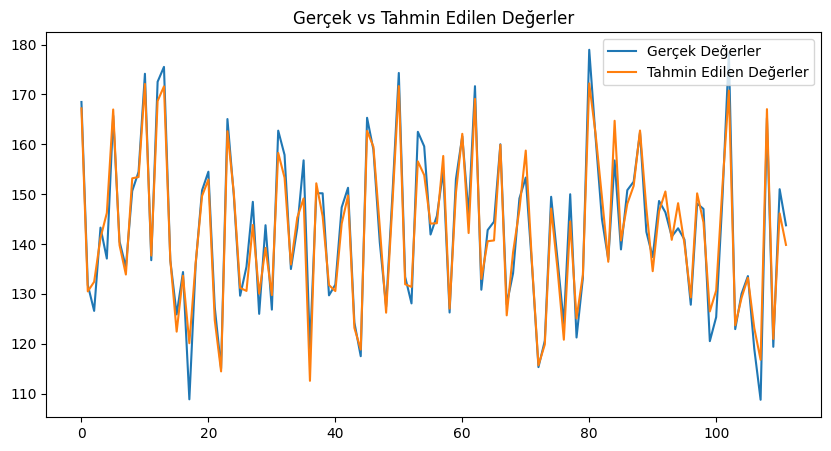

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Gerçek Değerler")
plt.plot(predictions_rescaled, label="Tahmin Edilen Değerler")
plt.title("Gerçek vs Tahmin Edilen Değerler")
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print("Ortalama Kare Hata (MSE):", mse)
print("R2 Skoru:", r2)


Ortalama Kare Hata (MSE): 12.518498119888777
R2 Skoru: 0.9504402344435493


In [34]:
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=100)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epo

In [44]:
# Girdi boyutunu kontrol etme
print(type(data['Close'].values))  # <class 'numpy.ndarray'> olmalı
print(data['Close'].values.ndim)  # 1 olmalı
print(data['Close'].values.shape)  # (n,) şeklinde olmalı

# Eğer boyut doğru değilse, veriyi düzeltme
if data['Close'].values.ndim > 1:
    close_prices = data['Close'].values.flatten()  # Tek boyuta indirge
else:
    close_prices = data['Close'].values

# RSI hesaplama
data['RSI'] = talib.RSI(close_prices, timeperiod=14)


<class 'numpy.ndarray'>
2
(556, 1)


In [45]:
# 'Close' sütununu tek boyutlu hale getirme
close_prices = data['Close'].values.flatten()  # Alternatif olarak .ravel() de kullanılabilir

# RSI hesaplama
data['RSI'] = talib.RSI(close_prices, timeperiod=14)

# Günlük yüzde değişim ekleme
data['Pct_Change'] = data['Close'].pct_change() * 100

# Özellikleri belirleme
features = data[['Close', 'Volume', 'MA50', 'MA200', 'RSI', 'Pct_Change']].values


In [46]:
print(data[['Close', 'RSI', 'Pct_Change']].head(20))


Price            Close        RSI Pct_Change
Ticker            AAPL                      
Date                                        
2020-10-15  120.709999        NaN        NaN
2020-10-16  119.019997        NaN  -1.400052
2020-10-19  115.980003        NaN  -2.554187
2020-10-20  117.510002        NaN   1.319192
2020-10-21  116.870003        NaN  -0.544634
2020-10-22  115.750000        NaN  -0.958332
2020-10-23  115.040001        NaN  -0.613390
2020-10-26  115.050003        NaN   0.008694
2020-10-27  116.599998        NaN   1.347236
2020-10-28  111.199997        NaN  -4.631219
2020-10-29  115.320000        NaN   3.705039
2020-10-30  108.860001        NaN  -5.601803
2020-11-02  108.769997        NaN  -0.082679
2020-11-03  110.440002        NaN   1.535355
2020-11-04  114.949997  41.149352   4.083660
2020-11-05  119.029999  48.150539   3.549371
2020-11-06  118.690002  47.641902  -0.285639
2020-11-09  116.320000  44.141534  -1.996801
2020-11-10  115.970001  43.631700  -0.300893
2020-11-11

In [60]:
# Veri indirme
data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")

# Sütunları düz bir yapıya dönüştürme
data.columns = data.columns.map(lambda x: x[0] if isinstance(x, tuple) else x)

# 'Close' sütununu kontrol edin
print(data.head())
print(data.columns)  # Sütun adlarının düz olduğunu kontrol edin


[*********************100%***********************]  1 of 1 completed

            Adj Close      Close       High        Low       Open     Volume
Date                                                                        
2020-01-02  72.796028  75.087502  75.150002  73.797501  74.059998  135480400
2020-01-03  72.088287  74.357498  75.144997  74.125000  74.287498  146322800
2020-01-06  72.662712  74.949997  74.989998  73.187500  73.447502  118387200
2020-01-07  72.320969  74.597504  75.224998  74.370003  74.959999  108872000
2020-01-08  73.484344  75.797501  76.110001  74.290001  74.290001  132079200
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [61]:
import talib

# RSI
data['RSI'] = talib.RSI(data['Close'].values.flatten(), timeperiod=14)
print(data[['Close', 'RSI']].dropna().head())

# MACD
data['MACD'], data['MACD_signal'], data['MACD_hist'] = talib.MACD(
    data['Close'].values.flatten(),
    fastperiod=12,
    slowperiod=26,
    signalperiod=9
)
print(data[['Close', 'MACD', 'MACD_signal']].dropna().head())

# Bollinger Bands
data['Upper_Band'], data['Middle_Band'], data['Lower_Band'] = talib.BBANDS(
    data['Close'].values.flatten(),
    timeperiod=20,
    nbdevup=2,
    nbdevdn=2,
    matype=0
)
print(data[['Close', 'Upper_Band', 'Lower_Band']].dropna().head())


                Close        RSI
Date                            
2020-01-23  79.807503  71.902570
2020-01-24  79.577499  70.286815
2020-01-27  77.237503  56.400682
2020-01-28  79.422501  63.626861
2020-01-29  81.084999  67.975967
                Close      MACD  MACD_signal
Date                                        
2020-02-20  80.074997  0.933719     1.121028
2020-02-21  78.262497  0.700786     1.036980
2020-02-24  74.544998  0.213750     0.872334
2020-02-25  72.019997 -0.371691     0.623529
2020-02-26  73.162498 -0.734995     0.351824
                Close  Upper_Band  Lower_Band
Date                                         
2020-01-30  80.967499   82.086011   73.932239
2020-01-31  77.377502   81.989006   74.258244
2020-02-03  77.165001   81.758195   74.769805
2020-02-04  79.712502   81.696760   75.307491
2020-02-05  80.362503   81.531967   76.048784


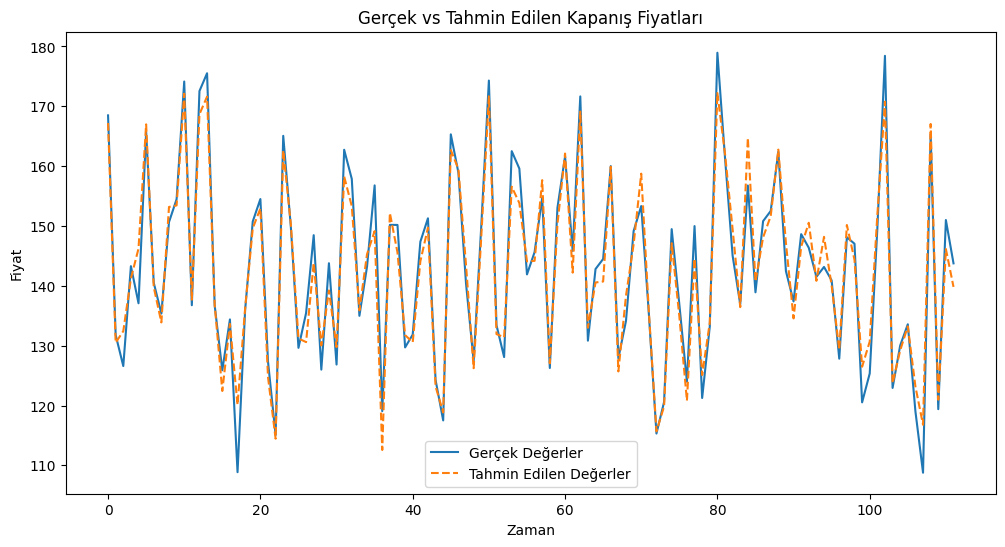

In [62]:
import matplotlib.pyplot as plt

# Tahmin edilen ve gerçek değerleri karşılaştırma
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Gerçek Değerler")
plt.plot(predictions_rescaled, label="Tahmin Edilen Değerler", linestyle="--")
plt.title("Gerçek vs Tahmin Edilen Kapanış Fiyatları")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.legend()
plt.show()


In [63]:
data['Momentum'] = talib.MOM(data['Close'].values.flatten(), timeperiod=10)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)


In [64]:
data['Price_Volume'] = data['Close'] * data['Volume']


In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['Close'], period=30)
data['Trend'] = decomposition.trend
data['Seasonality'] = decomposition.seasonal


In [72]:
from sklearn.model_selection import GridSearchCV

# Örnek: learning_rate, batch_size gibi parametreler için arama
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}
# Kendi model fonksiyonunuzu oluşturup deneyebilirsiniz


 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.


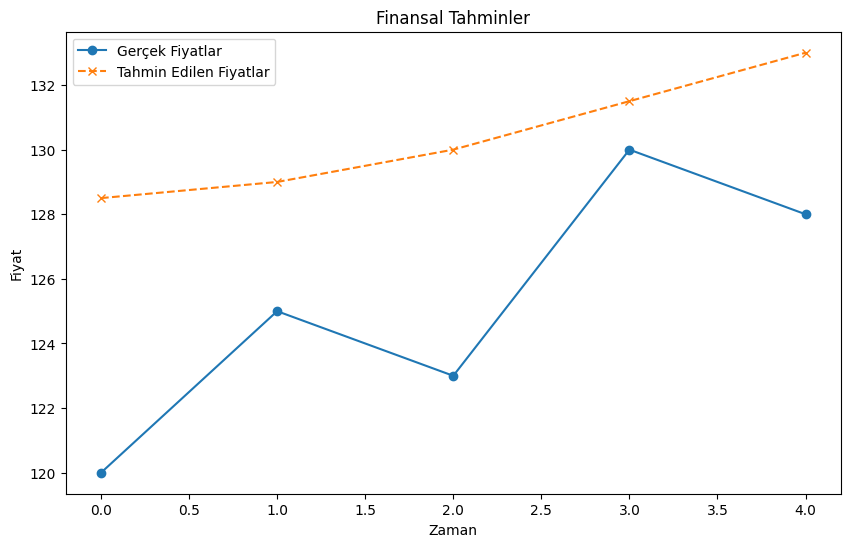

In [119]:
from flask import Flask, render_template
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
import nest_asyncio
from threading import Thread

# Jupyter Notebook'ta Flask'ı çalıştırmak için gerekli
nest_asyncio.apply()

app = Flask(__name__)

# Örnek veri ve tahminler
data = pd.DataFrame({'Close': [120, 125, 123, 130, 128]})  # Gerçek fiyatlar
live_predictions_rescaled = [[128.5], [129.0], [130.0], [131.5], [133.0]]  # Tahminler

@app.route("/")
def home():
    # Grafik oluşturma
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data['Close'], label="Gerçek Fiyatlar", marker="o")
    ax.plot([x[0] for x in live_predictions_rescaled], label="Tahmin Edilen Fiyatlar", linestyle="--", marker="x")
    ax.set_title("Finansal Tahminler")
    ax.set_xlabel("Zaman")
    ax.set_ylabel("Fiyat")
    ax.legend()

    # Grafiği base64 formatına dönüştürme
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plot_url = base64.b64encode(buf.getvalue()).decode()
    buf.close()

    # HTML sayfasına veri gönderme
    return f"""
    <h1>Gerçek Zamanlı Finansal Tahmin Platformu</h1>
    <h2>Son Tahmin: {live_predictions_rescaled[-1][0]:.2f}</h2>
    <img src="data:image/png;base64,{plot_url}" alt="Finansal Tahmin Grafiği">
    """

# Flask sunucusunu başlatma
def run_app():
    app.run(port=5001)  # 5001 numaralı portu kullan

# Flask'ı ayrı bir iş parçacığında çalıştırma
thread = Thread(target=run_app)
thread.start()


In [76]:
data['Z_Score'] = (data['Close'] - data['Close'].mean()) / data['Close'].std()
anomalies = data[data['Z_Score'] > 3]  # Anormal fiyatlar


Ağırlıklar: [0.54577087 0.45422913]
Beklenen Yıllık Getiri: 3.41
Beklenen Volatilite: 0.49


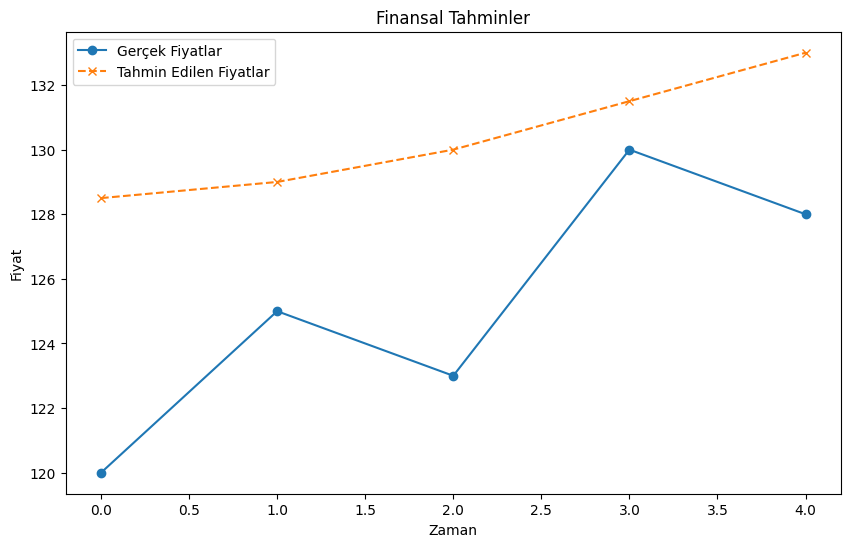

In [78]:
import numpy as np
import pandas as pd

# Örnek hisse senedi verileri
data = pd.DataFrame({
    'AAPL': [120, 125, 123, 130, 128],
    'MSFT': [210, 215, 213, 220, 218]
})

# Günlük getiriler
returns = data.pct_change().dropna()

# Ortalama getiriler
mean_returns = returns.mean()

# Kovaryans matrisi
cov_matrix = returns.cov()

# Örnek portföy optimizasyonu
weights = np.random.random(len(data.columns))
weights /= np.sum(weights)

# Beklenen yıllık getiri
expected_return = np.sum(mean_returns * weights) * 252

# Yıllık volatilite
expected_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

print(f"Ağırlıklar: {weights}")
print(f"Beklenen Yıllık Getiri: {expected_return:.2f}")
print(f"Beklenen Volatilite: {expected_volatility:.2f}")


In [82]:
import numpy as np
import pandas as pd

# Örnek veri çerçevesi: Çok düzeyli indeks yapısı olabileceğini varsayıyoruz
data = pd.DataFrame({
    ('Price', 'Close'): [120, 125, 123, 130, 128],
    ('Price', 'Open'): [118, 124, 122, 128, 126],
    ('Volume', ''): [1000, 1100, 1050, 1150, 1200]
})

# Çok düzeyli sütun yapısını kontrol edin
print("Orijinal sütunlar:")
print(data.columns)

# Çok düzeyli sütunları düzleştirin
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    print("\nDüzleştirilmiş sütunlar:")
    print(data.columns)

# Artık sütunlara şu şekilde erişebilirsiniz:
# 'Price_Close' gibi bir sütun adı oluşturulmuş olur

# Günlük getiriler
if 'Price_Close' in data.columns:
    returns = data['Price_Close'].pct_change().dropna()
else:
    print("Hata: 'Price_Close' sütunu bulunamadı.")

# Ortalama günlük getiri
mean_return = returns.mean()

# Standart sapma (volatilite)
volatility = returns.std() * np.sqrt(252)  # Yıllık volatilite

# Beklenen yıllık getiri
expected_return = mean_return * 252

print(f"\nBeklenen Yıllık Getiri: {expected_return:.2f}")
print(f"Yıllık Volatilite: {volatility:.2f}")


Orijinal sütunlar:
MultiIndex([( 'Price', 'Close'),
            ( 'Price',  'Open'),
            ('Volume',      '')],
           )

Düzleştirilmiş sütunlar:
Index(['Price_Close', 'Price_Open', 'Volume_'], dtype='object')

Beklenen Yıllık Getiri: 4.23
Yıllık Volatilite: 0.60


In [83]:
import yfinance as yf

# Birden fazla hisse senedi için veri çekme
tickers = ['AAPL', 'MSFT', 'GOOG']
data = yf.download(tickers, start='2023-01-01', end='2023-12-01')['Adj Close']

# Günlük getiriler
returns = data.pct_change().dropna()

# Ortalama getiriler ve kovaryans matrisi
mean_returns = returns.mean()
cov_matrix = returns.cov()

print(mean_returns)
print(cov_matrix)


[*********************100%***********************]  3 of 3 completed

Ticker
AAPL    0.001933
GOOG    0.001943
MSFT    0.002174
dtype: float64
Ticker      AAPL      GOOG      MSFT
Ticker                              
AAPL    0.000165  0.000138  0.000116
GOOG    0.000138  0.000382  0.000167
MSFT    0.000116  0.000167  0.000265


In [84]:
# Rastgele ağırlıklar
weights = np.random.random(len(mean_returns))
weights /= np.sum(weights)

# Beklenen yıllık getiri
expected_return = np.sum(mean_returns * weights) * 252

# Beklenen volatilite
expected_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

print(f"Portföy Ağırlıkları: {weights}")
print(f"Beklenen Yıllık Getiri: {expected_return:.2f}")
print(f"Beklenen Volatilite: {expected_volatility:.2f}")


Portföy Ağırlıkları: [0.09178057 0.47926782 0.42895162]
Beklenen Yıllık Getiri: 0.51
Beklenen Volatilite: 0.24


Index(['Price_Close', 'Price_Open', 'Volume_'], dtype='object')


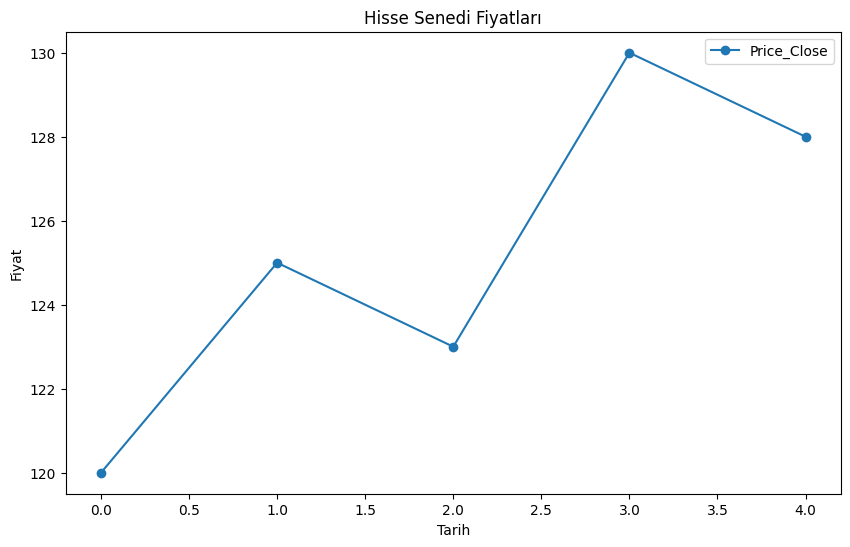

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

# Örnek veri çerçevesi
data = pd.DataFrame({
    ('Price', 'Close'): [120, 125, 123, 130, 128],
    ('Price', 'Open'): [118, 124, 122, 128, 126],
    ('Volume', ''): [1000, 1100, 1050, 1150, 1200]
})

# Çok düzeyli sütunları düzleştirme
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Sütunları kontrol et
print(data.columns)

# Sütunun varlığını kontrol et ve çizim yap
if 'Price_Close' in data.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(data['Price_Close'], label='Price_Close', marker='o')
    plt.title('Hisse Senedi Fiyatları')
    plt.xlabel('Tarih')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.show()
else:
    print("Hata: 'Price_Close' sütunu bulunamadı.")


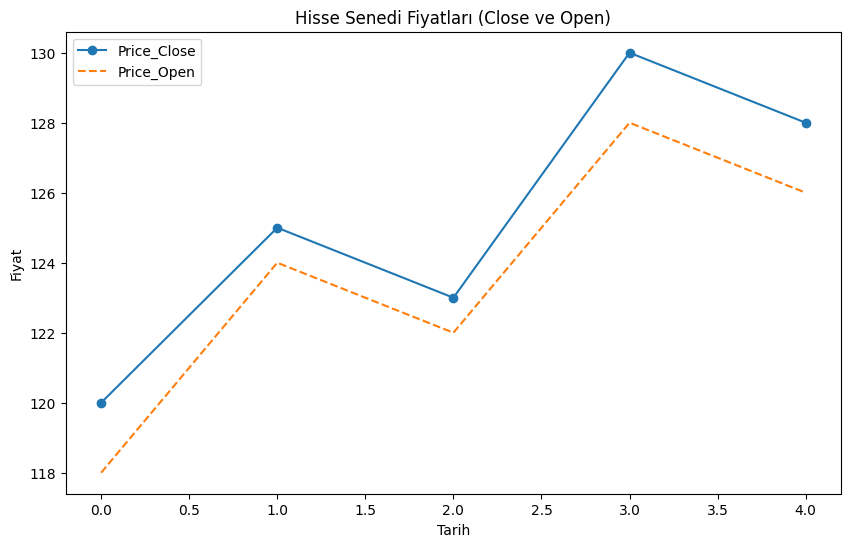

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(data['Price_Close'], label='Price_Close', marker='o')
plt.plot(data['Price_Open'], label='Price_Open', linestyle='--')
plt.title('Hisse Senedi Fiyatları (Close ve Open)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


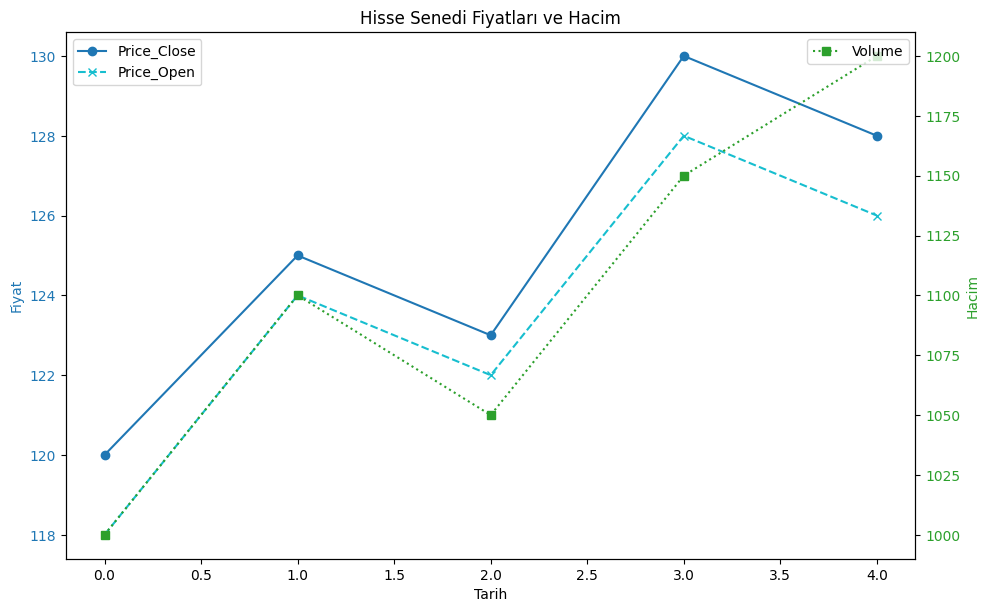

In [94]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Fiyatlar için ilk eksen
ax1.set_xlabel('Tarih')
ax1.set_ylabel('Fiyat', color='tab:blue')
ax1.plot(data['Price_Close'], label='Price_Close', color='tab:blue', marker='o')
ax1.plot(data['Price_Open'], label='Price_Open', color='tab:cyan', linestyle='--', marker='x')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Hacim için ikinci eksen
ax2 = ax1.twinx()
ax2.set_ylabel('Hacim', color='tab:green')
ax2.plot(data['Volume_'], label='Volume', color='tab:green', linestyle=':', marker='s')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Hisse Senedi Fiyatları ve Hacim')
plt.show()


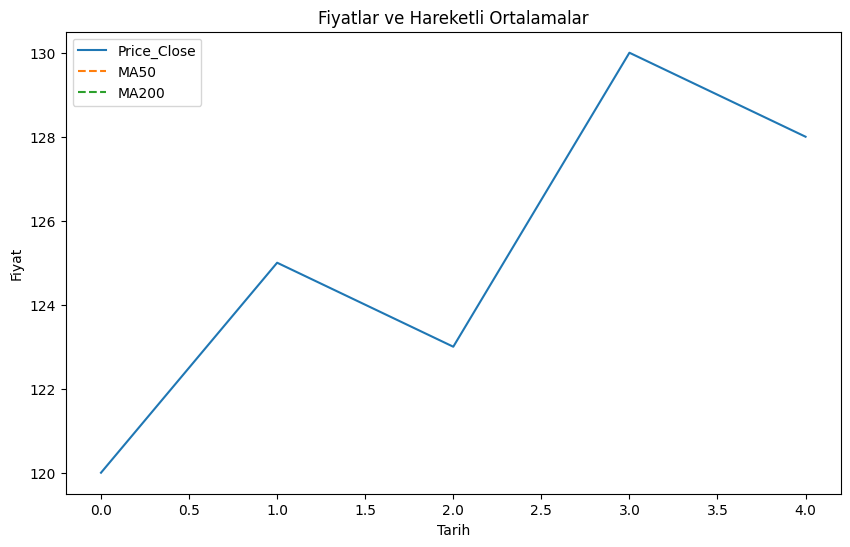

In [95]:
data['MA50'] = data['Price_Close'].rolling(window=50).mean()
data['MA200'] = data['Price_Close'].rolling(window=200).mean()

plt.figure(figsize=(10, 6))
plt.plot(data['Price_Close'], label='Price_Close')
plt.plot(data['MA50'], label='MA50', linestyle='--')
plt.plot(data['MA200'], label='MA200', linestyle='--')
plt.title('Fiyatlar ve Hareketli Ortalamalar')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


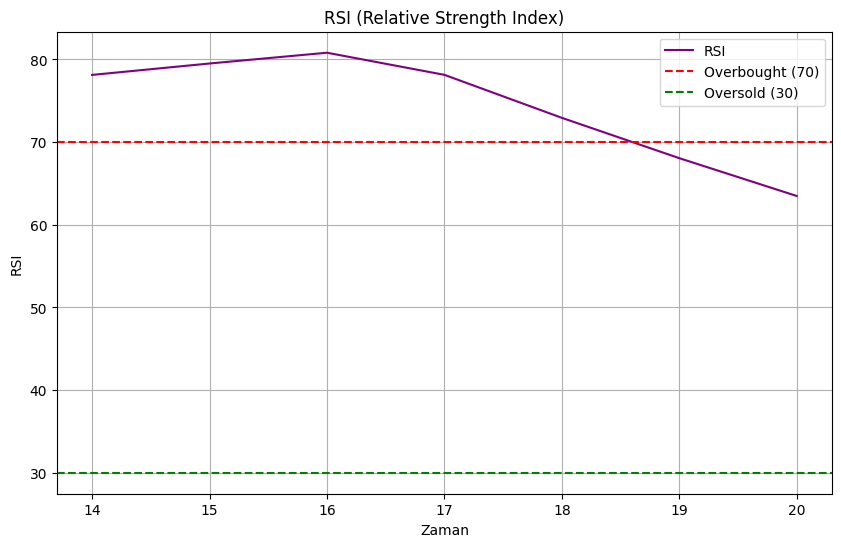

    Price_Close        RSI
0           120        NaN
1           125        NaN
2           123        NaN
3           130        NaN
4           128        NaN
5           127        NaN
6           129        NaN
7           130        NaN
8           131        NaN
9           134        NaN
10          135        NaN
11          133        NaN
12          136        NaN
13          137        NaN
14          138  78.125000
15          140  79.504505
16          142  80.807917
17          141  78.132391
18          139  72.931417
19          137  68.052931
20          135  63.480026


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import talib

# Örnek fiyat verileri
data = pd.DataFrame({
    'Price_Close': [120, 125, 123, 130, 128, 127, 129, 130, 131, 134, 135, 133, 136, 137, 138, 140, 142, 141, 139, 137, 135]
})

# RSI Hesaplama (14 periyotluk RSI)
data['RSI'] = talib.RSI(data['Price_Close'].astype(float).values, timeperiod=14)

# RSI grafiği
plt.figure(figsize=(10, 6))
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (Relative Strength Index)')
plt.xlabel('Zaman')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()

# Veri çerçevesini göster
print(data)


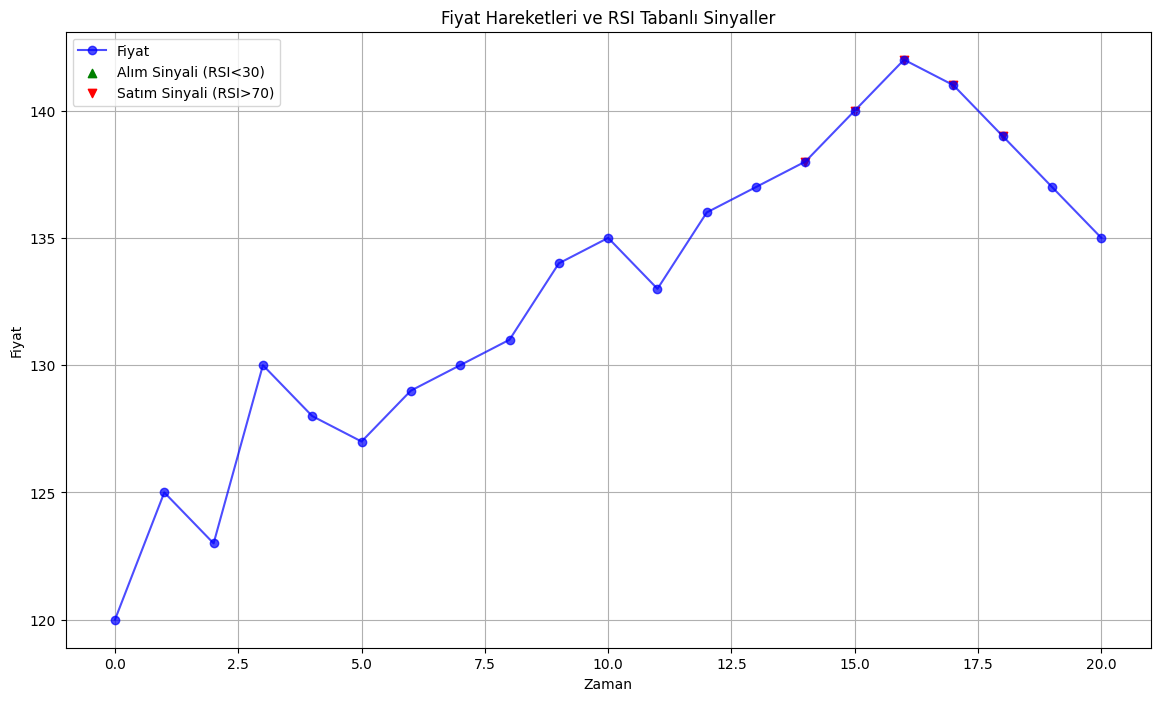

    Price_Close        RSI  Buy_Signal  Sell_Signal
0           120        NaN         NaN          NaN
1           125        NaN         NaN          NaN
2           123        NaN         NaN          NaN
3           130        NaN         NaN          NaN
4           128        NaN         NaN          NaN
5           127        NaN         NaN          NaN
6           129        NaN         NaN          NaN
7           130        NaN         NaN          NaN
8           131        NaN         NaN          NaN
9           134        NaN         NaN          NaN
10          135        NaN         NaN          NaN
11          133        NaN         NaN          NaN
12          136        NaN         NaN          NaN
13          137        NaN         NaN          NaN
14          138  78.125000         NaN        138.0
15          140  79.504505         NaN        140.0
16          142  80.807917         NaN        142.0
17          141  78.132391         NaN        141.0
18          

In [104]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt

# Veri örneği
data = pd.DataFrame({
    'Price_Close': [120, 125, 123, 130, 128, 127, 129, 130, 131, 134, 135, 133, 136, 137, 138, 140, 142, 141, 139, 137, 135]
})

# RSI hesaplama
data['RSI'] = talib.RSI(data['Price_Close'], timeperiod=14)

# Alım ve Satım sinyalleri
data['Buy_Signal'] = np.where(data['RSI'] < 30, data['Price_Close'], np.nan)
data['Sell_Signal'] = np.where(data['RSI'] > 70, data['Price_Close'], np.nan)

# Grafik oluşturma
plt.figure(figsize=(14, 8))
plt.plot(data['Price_Close'], label='Fiyat', marker='o', color='blue', alpha=0.7)
plt.scatter(data.index, data['Buy_Signal'], label='Alım Sinyali (RSI<30)', marker='^', color='green', alpha=1)
plt.scatter(data.index, data['Sell_Signal'], label='Satım Sinyali (RSI>70)', marker='v', color='red', alpha=1)
plt.title('Fiyat Hareketleri ve RSI Tabanlı Sinyaller')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.grid()
plt.show()

# Sonuçları yazdırma
print(data)


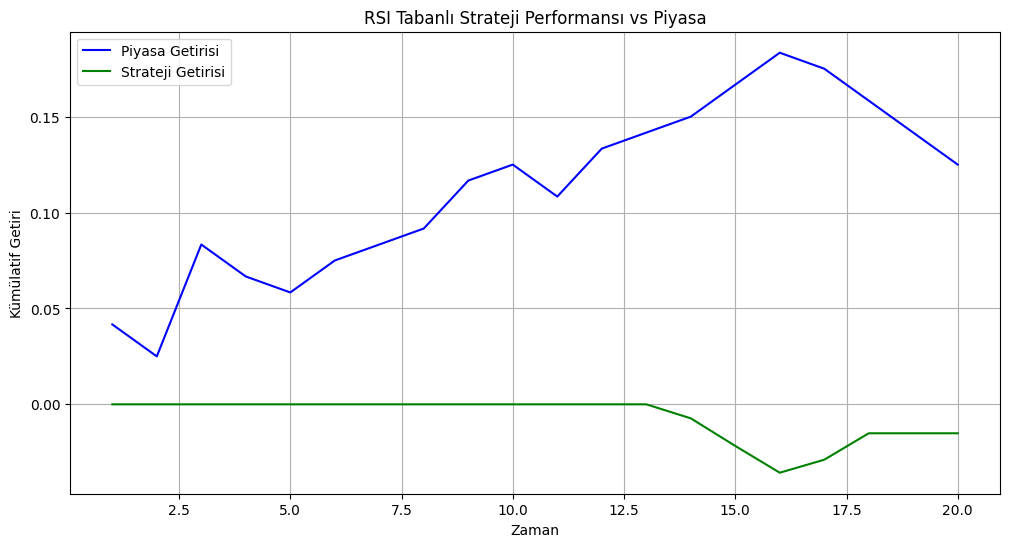

    Price_Close        RSI  Buy_Signal  Sell_Signal  Position  Daily_Return  \
0           120        NaN         NaN          NaN         0           NaN   
1           125        NaN         NaN          NaN         0      0.041667   
2           123        NaN         NaN          NaN         0     -0.016000   
3           130        NaN         NaN          NaN         0      0.056911   
4           128        NaN         NaN          NaN         0     -0.015385   
5           127        NaN         NaN          NaN         0     -0.007812   
6           129        NaN         NaN          NaN         0      0.015748   
7           130        NaN         NaN          NaN         0      0.007752   
8           131        NaN         NaN          NaN         0      0.007692   
9           134        NaN         NaN          NaN         0      0.022901   
10          135        NaN         NaN          NaN         0      0.007463   
11          133        NaN         NaN          NaN 

In [105]:
# Pozisyonları tanımla: Alım ve satım sinyallerine göre
data['Position'] = 0
data.loc[data['Buy_Signal'].notnull(), 'Position'] = 1  # Alım sinyali için pozisyon aç
data.loc[data['Sell_Signal'].notnull(), 'Position'] = -1  # Satım sinyali için pozisyon kapat
data['Position'] = data['Position'].ffill().fillna(0)  # Pozisyonları ileri taşı

# Günlük getirileri hesapla
data['Daily_Return'] = data['Price_Close'].pct_change()
data['Strategy_Return'] = data['Daily_Return'] * data['Position']

# Kümülatif getirileri hesapla
data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod() - 1
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod() - 1

# Performans grafiği
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Market_Return'], label='Piyasa Getirisi', color='blue')
plt.plot(data['Cumulative_Strategy_Return'], label='Strateji Getirisi', color='green')
plt.title('RSI Tabanlı Strateji Performansı vs Piyasa')
plt.xlabel('Zaman')
plt.ylabel('Kümülatif Getiri')
plt.legend()
plt.grid()
plt.show()

# Performans özet tablosu
print(data[['Price_Close', 'RSI', 'Buy_Signal', 'Sell_Signal', 'Position', 'Daily_Return', 'Strategy_Return', 'Cumulative_Strategy_Return']])


In [125]:
returns = data['Price_Close'].pct_change().dropna()
mean_return = returns.mean() * 252  # Yıllık Getiri
volatility = returns.std() * np.sqrt(252)  # Yıllık Volatilite

print(f"Beklenen Yıllık Getiri: {mean_return:.2f}")
print(f"Yıllık Volatilite: {volatility:.2f}")


[*********************100%***********************]  1 of 1 completed

Veri Çerçevesindeki Sütunlar:
MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Hata: 'Price_Close' sütunu bulunamadı!
Price_Close sütunu yerine 'Close' sütunu kullanılacak.
Ortalama Kare Hata (MSE): 1.79
Ortalama Mutlak Hata (MAE): 1.30


In [127]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Veri çerçevesinin sütunlarını kontrol et
data = yf.download('AAPL', start="2020-01-01", end="2023-01-01")

print("Veri Çerçevesindeki Sütunlar:")
print(data.columns)  # Bu satırla sütun isimlerini kontrol edebilirsiniz

# Price_Close sütununun olup olmadığını kontrol edelim
if 'Price_Close' not in data.columns:
    print("Hata: 'Price_Close' sütunu bulunamadı!")
    # Eğer 'Price_Close' yoksa, veri çerçevesindeki 'Close' sütununu kullanabiliriz
    if 'Close' in data.columns:
        print("Price_Close sütunu yerine 'Close' sütunu kullanılacak.")
        data['Price_Close'] = data['Close']
    else:
        print("Hata: 'Close' sütunu da bulunamadı.")
        exit()

# Tahminler (örnek veri ile çalıştırılabilir)
predictions = data['Price_Close'] * 0.99  # Dummy prediction örneği

# Hata Analizi
mse = mean_squared_error(data['Price_Close'], predictions)
mae = mean_absolute_error(data['Price_Close'], predictions)

# Sonuçları yazdır
print(f"Ortalama Kare Hata (MSE): {mse:.2f}")
print(f"Ortalama Mutlak Hata (MAE): {mae:.2f}")


[*********************100%***********************]  1 of 1 completed

Veri Çerçevesindeki Sütunlar:
MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Hata: 'Price_Close' sütunu bulunamadı!
Price_Close sütunu yerine 'Close' sütunu kullanılacak.
Ortalama Kare Hata (MSE): 1.79
Ortalama Mutlak Hata (MAE): 1.30
